### References:

Darmet, L., Ladouce, S., & Dehais, F. (2023). **Shortened calibration of code-VEP based BCI by improved deep learning 
architecture and golden subjects pre-training.** *In 11th International IEEE EMBS Conference on Neural Engineering.* 

Source: https://github.com/neuroergoISAE/offline_cVEP_bitwise

Thielen, J., Marsman, P., Farquhar, J., & Desain, P. (2021). **From full calibration to zero training for a code-modulated
visual evoked potentials for brain–computer interface**. *Journal of Neural Engineering, 18(5), 056007.*

Source: https://gitlab.socsci.ru.nl/jthielen/pynt/-/blob/main/examples

Sebastian Nagel

Source: https://github.com/thecodingdad/eeg2code

Teulings, D.E.J. David (2022).  **an-application-of-recurrency-to-eeg2code-deep-learning**

Source: https://gitlab.socsci.ru.nl/D.Teulings/an-application-of-recurrency-to-eeg2code-deep-learning/-/tree/master

In [1]:
# the path to the dataset
path = 'D:/Dataset'

import seaborn as sns
sns.set_context("paper", font_scale=2)

In [2]:
import os
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
import pynt
import keras
import sys
import scipy.io as sio
import tensorflow as tf
import time
import seaborn
import random
import keras.utils as ku
from scipy import stats
from scipy.stats import wilcoxon
from keras.optimizers import adam
from keras.callbacks import History 
from sklearn.metrics import accuracy_score
from tensorflow.python.keras import backend
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras import initializers
from keras.models import load_model
from keras.models import Sequential
from keras.layers import (Input,
                          InputLayer,
                          GRU,
                          RNN,
                          LSTM,
                          Reshape,
                          SimpleRNN,
                          Conv1D,
                          Conv2D,
                          MaxPooling1D,
                          MaxPooling2D,
                          Permute,
                          Flatten, 
                          Dense,
                          BatchNormalization, 
                          Activation,
                          Dropout
                         )
from scipy.io import loadmat
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cross_decomposition import CCA
from tensorflow.python.keras import backend
from tensorflow.keras.models import load_model

# Settings
### Hyperparameters, function that load data, and function that slicing data to epoch

In [23]:
"""
Hyperparameters.

subject = ['sub-01','sub-02', 'sub-03', 'sub-04', 'sub-05','sub-06','sub-07', 'sub-08', 'sub-09', 'sub-10'
           ,'sub-11','sub-22', 'sub-13', 'sub-14', 'sub-15','sub-16','sub-17', 'sub-18', 'sub-19', 'sub-20'
           ,'sub-21','sub-22', 'sub-23', 'sub-24', 'sub-25','sub-26','sub-27', 'sub-28', 'sub-29', 'sub-30']
epoch_size: 0.3 * 512 sampling frequency = 90 window size
step_size: 1 / 60 frame rate * 512 sampling frequency = 5
learning rate: 0.001 same as EEG2Code paper
batch size: 256 same as EEG2Code paper
    Mini-batch gradient descent
epochs: 30 (25 on EE2Code paper)
    Number of iterations
Optimizers: RMSProp
n_folds: 5 k-fold cross validation
"""
subjects = ['sub-01','sub-02', 'sub-03', 'sub-04', 'sub-05','sub-06','sub-07', 'sub-08', 'sub-09', 'sub-10'
           ,'sub-11','sub-22', 'sub-13', 'sub-14', 'sub-15','sub-16','sub-17', 'sub-18', 'sub-19', 'sub-20'
           ,'sub-21','sub-22', 'sub-23', 'sub-24', 'sub-25','sub-26','sub-27', 'sub-28', 'sub-29', 'sub-30']
epoch_size = int(300 * 0.3)
step_size = int(1 / 60 * 300)
epochs = 30
n_folds = 5

In [24]:
"""
Pre-processed settings

band_pass: [2.0 Hz, 30.0 Hz]
    Bandpass cutoffs in Hz for spectral filtering
tmin: 0.0 sec
    Trial onset in seconds for slicing
tmax: 31.5 sec
    Trial end in seconds for slicing
    
Load data.

X: (100 trials, 8 channels, 9450 samples)
    EEG time-series data
V: (630 samples, 20 classes/labels/symbols)
    Codes matrix. Codebook
y: (100 trials,)
    Label vector of 100 trials
fs = 300 Hz
    Target sampling frequency (avg of sampels obtained in one sec) in Hz for resampling
"""
def load_data(subject):
    fn = os.path.join(path, 'derivatives300', 'offline', subject, f'{subject}_gdf.npz')
    tmp = np.load(fn)
    X = tmp['X']
    V = tmp['V']
    y = tmp['y']
    fs = tmp['fs']
    return X, V, y, fs

In [25]:
"""
Slices trials to epochs.

Returns:
    X_sliced: (100 trials, 1872 epochs, 8 channels, 90 window size)
        The sliced EEG data of shape with epoch
    y_sliced: (100 trials, 1872 epochs)
        The sliced label information of shape with epoch
"""
def trials_to_epochs(X, y, codes, epoch_size, step_size):
    n_trials, n_channels, n_samples = X.shape
    n_epochs = int((n_samples - epoch_size) / step_size)
    X_sliced = np.zeros((n_trials, n_epochs, n_channels, epoch_size), 
        dtype='float32')
    y_sliced = np.zeros((n_trials, n_epochs), dtype='uint8')
    for i_epoch in range(n_epochs):
        start = i_epoch * step_size
        X_sliced[:, i_epoch, :, :] = X[:, :, start:start+epoch_size]
        y_sliced[:, i_epoch] = codes[start % codes.shape[0], y]
    return X_sliced, y_sliced

# Evaluation
### Load data

In [26]:
"""
Open training history
"""
def load_history(path, subject, i_fold):
    with open(path, 'r') as f:
        print(f'File found for {subject}_fold_{i_fold+1}')
        history = json.load(f)
    return history

# Load model training histories with fold_hists[n_folds][{subject}] or put zero values if file is not available
fold_hists = []
for i_fold in range(n_folds):
    fold_hist = []
    for subject in subjects:
        try:
            hist = load_history(os.path.join(path, 'history2', f'{subject}_fold_{i_fold+1}_EEG2Codehistory.json'), subject, i_fold)
            converted_history = {}
            for key, inner_dict in hist.items():
                values = list(inner_dict.values())
                converted_history[key] = values
            fold_hist.append(converted_history)
        except FileNotFoundError:
            print(f'File not found for {subject}_fold_{i_fold+1} Skipping...')
            fold_hist.append({'loss': [0] * epochs, 'accuracy': [0] * epochs, 'val_loss': [0] * epochs, 'val_accuracy': [0] * epochs})
    fold_hists.append(fold_hist)
    
# Make arraies with list of history for each fold
train_accuracies = []
valid_accuracies = []
train_losses = []
valid_losses = []

for i in range(n_folds):
    train_accuracies.append([])
    valid_accuracies.append([])
    train_losses.append([])
    valid_losses.append([])
    for hist in fold_hists[i]:
        train_accuracies[i].append(hist['accuracy'])
        valid_accuracies[i].append(hist['val_accuracy'])
        train_losses[i].append(hist['loss'])
        valid_losses[i].append(hist['val_loss'])

# Load methods averaged epoch and trial accuracy for all subjects
LDA_acc_epoch = np.loadtxt(os.path.join(path, 'history2', 'LDA_epoch_accuracies.txt'), dtype=str).astype(float).tolist()
LDA_acc_trial = np.loadtxt(os.path.join(path, 'history2', 'LDA_trial_accuracies.txt'), dtype=str).astype(float).tolist()
CCA_acc_epoch = np.loadtxt(os.path.join(path, 'history2', 'CCALDA_epoch_accuracies.txt'), dtype=str).astype(float).tolist()
CCA_acc_epoch = np.loadtxt(os.path.join(path, 'history2', 'CCALDA_trial_accuracies.txt'), dtype=str).astype(float).tolist()
EEG2Code_acc_epoch = np.loadtxt(os.path.join(path, 'history2', 'EEG2Code_epoch_accuracies.txt'), dtype=str).astype(float).tolist()
EEG2Code_acc_trial = np.loadtxt(os.path.join(path, 'history2', 'EEG2Code_trial_accuracies.txt'), dtype=str).astype(float).tolist()

# Load epoch predictions of all participants for all fold and epoch (n_subjects,n_folds,n_trials/n_folds*epochs)
epoch_predictions_saveall_lda = np.load(os.path.join(path, 'history2', 'epoch_predictions_saveall_lda.npy'))
epoch_predictions_saveall_cca = np.load(os.path.join(path, 'history2', 'epoch_predictions_saveall_ldacca.npy'))
epoch_predictions_saveall_eeg2code = np.load(os.path.join(path, 'history2', 'epoch_predictions_saveall_eeg2code.npy'))


File found for sub-01_fold_1
File found for sub-02_fold_1
File found for sub-03_fold_1
File found for sub-04_fold_1
File found for sub-05_fold_1
File found for sub-06_fold_1
File found for sub-07_fold_1
File found for sub-08_fold_1
File found for sub-09_fold_1
File found for sub-10_fold_1
File found for sub-11_fold_1
File found for sub-22_fold_1
File found for sub-13_fold_1
File found for sub-14_fold_1
File found for sub-15_fold_1
File found for sub-16_fold_1
File found for sub-17_fold_1
File found for sub-18_fold_1
File found for sub-19_fold_1
File found for sub-20_fold_1
File found for sub-21_fold_1
File found for sub-22_fold_1
File found for sub-23_fold_1
File found for sub-24_fold_1
File found for sub-25_fold_1
File found for sub-26_fold_1
File found for sub-27_fold_1
File found for sub-28_fold_1
File found for sub-29_fold_1
File found for sub-30_fold_1
File found for sub-01_fold_2
File found for sub-02_fold_2
File found for sub-03_fold_2
File found for sub-04_fold_2
File found for

### EEG2Code training accuracies and losses

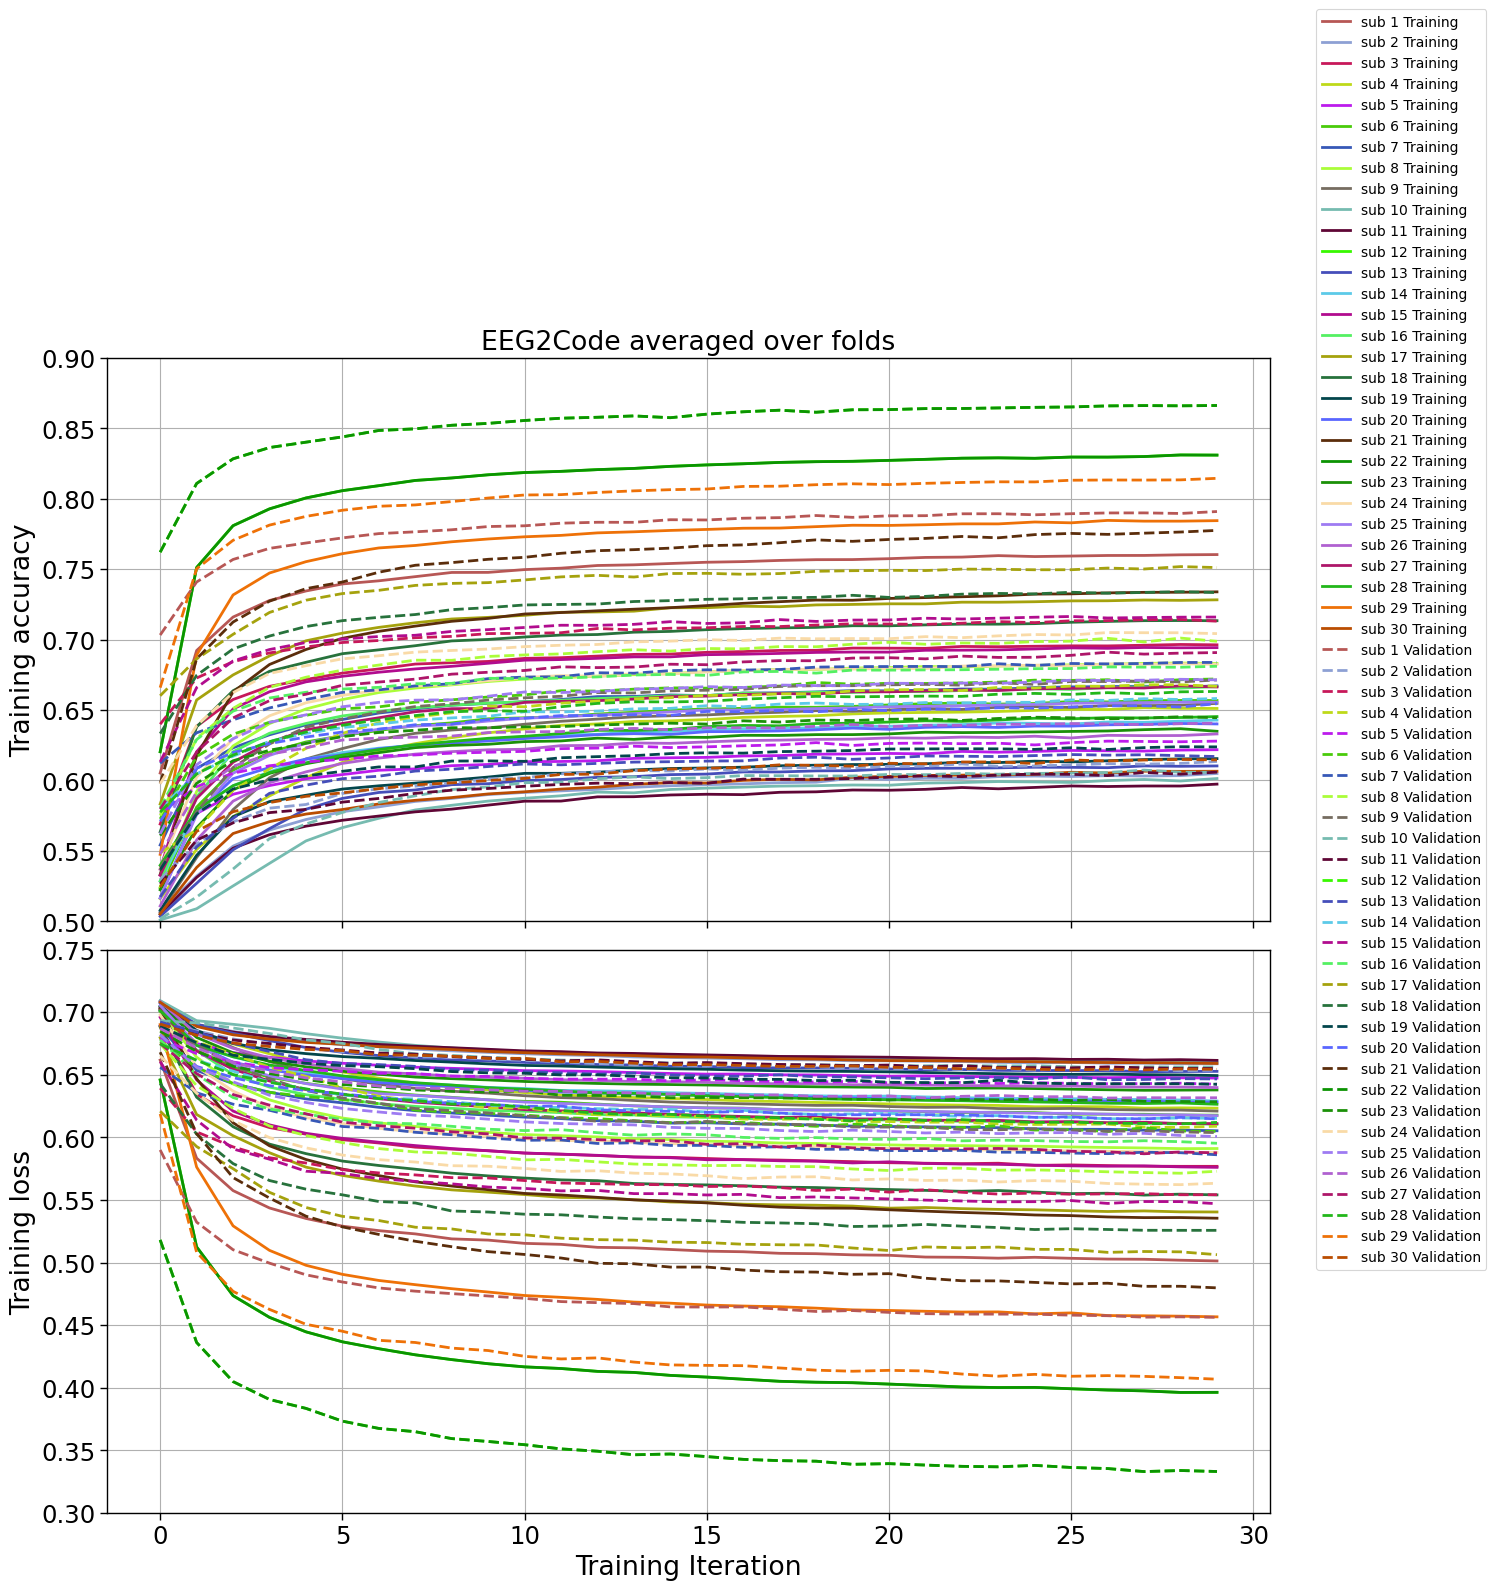

In [30]:
# Averages fold training history
def average_folds(training):
    training = np.array(training)
    averages = np.mean(training, axis=0)
    return averages.tolist()
train_accuracies_avg = average_folds(train_accuracies)
valid_accuracies_avg = average_folds(valid_accuracies)
train_losses_avg = average_folds(train_losses)
valid_losses_avg = average_folds(valid_losses)

# Generate colors for each subjects
line_color = ['#' + ''.join(random.choices('0123456789ABCDEF', k=6)) for _ in range(30)]

#Plot accuracy for all subjects
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(15, 15))
plt.subplots_adjust(wspace=0, hspace=0.05)

# Plot accuracies
for i, acc in enumerate(train_accuracies_avg):
    ax1.plot(range(len(acc)), acc, color=line_color[i], label=f'sub {i+1} Training', linestyle='-', linewidth=2)

# Plot validation accuracies
for i, val_acc in enumerate(valid_accuracies_avg):
    ax1.plot(range(len(val_acc)), val_acc, color=line_color[i], label=f'sub {i+1} Validation', linestyle='--', linewidth=2)
ax1.set_ylim(0.5, 0.9)
ax1.set_title('EEG2Code averaged over folds')
ax1.set_ylabel('Training accuracy')
ax1.set_xticklabels([])
ax1.legend(bbox_to_anchor=(1.04, 0.5), loc='center left', borderaxespad=0, fontsize = 10)
ax1.grid(True)

# Plot losses
for i, loss in enumerate(train_losses_avg):
    ax2.plot(range(len(loss)), loss, color=line_color[i], linestyle='-', linewidth=2)

# Plot validation losses
for i, val_loss in enumerate(valid_losses_avg):
    ax2.plot(range(len(val_loss)), val_loss, color=line_color[i], linestyle='--', linewidth=2)
ax2.set_ylim(0.3, 0.75)
ax2.set_xlabel('Training Iteration')
ax2.set_ylabel('Training loss')
ax2.tick_params(axis='both')
ax2.grid(True, which='both')

# Save plot
fig.savefig('EEG2Code training accuracy and loss.png', bbox_inches='tight')
fig.savefig('EEG2Code training accuracy and loss.svg', format='svg',transparent=True)
plt.show()

### Testing EEG decoding methods

In [32]:
# Get accuracies history
EEG2Code_acc_epoch = []
with open(os.path.join(path, 'history2', 'EEG2Code_epoch_accuracies.txt'), 'r') as fp:
    for line in fp:
        # remove linebreak from a current name
        # linebreak is the last character of each line
        x = line[:-1]
        # add current item to the list
        EEG2Code_acc_epoch.append(x)
EEG2Code_acc_epoch = [float(value) for value in EEG2Code_acc_epoch]
EEG2Code_acc_trial = []
with open(os.path.join(path, 'history2', 'EEG2Code_trial_accuracies.txt'), 'r') as fp:
    for line in fp:
        # remove linebreak from a current name
        # linebreak is the last character of each line
        x = line[:-1]
        # add current item to the list
        EEG2Code_acc_trial.append(x)
EEG2Code_acc_trial = [float(value) for value in EEG2Code_acc_trial]
LDA_acc_epoch = []
with open(os.path.join(path, 'history2', 'LDA_epoch_accuracies.txt'), 'r') as fp:
    for line in fp:
        # remove linebreak from a current name
        # linebreak is the last character of each line
        x = line[:-1]
        # add current item to the list
        LDA_acc_epoch.append(x)
LDA_acc_epoch = [float(value) for value in LDA_acc_epoch]
LDA_acc_trial = []
with open(os.path.join(path, 'history2', 'LDA_trial_accuracies.txt'), 'r') as fp:
    for line in fp:
        # remove linebreak from a current name
        # linebreak is the last character of each line
        x = line[:-1]
        # add current item to the list
        LDA_acc_trial.append(x)
LDA_acc_trial = [float(value) for value in LDA_acc_trial]
CCA_acc_epoch = []
with open(os.path.join(path, 'history2', 'CCALDA_epoch_accuracies.txt'), 'r') as fp:
    for line in fp:
        # remove linebreak from a current name
        # linebreak is the last character of each line
        x = line[:-1]
        # add current item to the list
        CCA_acc_epoch.append(x)
CCA_acc_epoch = [float(value) for value in CCA_acc_epoch]
CCA_acc_trial = []
with open(os.path.join(path, 'history2', 'CCALDA_trial_accuracies.txt'), 'r') as fp:
    for line in fp:
        # remove linebreak from a current name
        # linebreak is the last character of each line
        x = line[:-1]
        # add current item to the list
        CCA_acc_trial.append(x)
CCA_acc_trial = [float(value) for value in CCA_acc_trial]

# Find mean and std of accuracies for p-value test
EEG2Code_acc_epoch_mean = np.mean(EEG2Code_acc_epoch)
EEG2Code_acc_trial_mean = np.mean(EEG2Code_acc_trial)
EEG2Code_acc_epoch_std = np.std(EEG2Code_acc_epoch)
EEG2Code_acc_trial_std = np.std(EEG2Code_acc_trial)
LDA_acc_epoch_mean = np.mean(LDA_acc_epoch)
LDA_acc_trial_mean = np.mean(LDA_acc_trial)
LDA_acc_epoch_std = np.std(LDA_acc_epoch)
LDA_acc_trial_std = np.std(LDA_acc_trial)
CCA_acc_epoch_mean = np.mean(CCA_acc_epoch)
CCA_acc_trial_mean = np.mean(CCA_acc_trial)
CCA_acc_epoch_std = np.std(CCA_acc_epoch)
CCA_acc_trial_std = np.std(CCA_acc_trial)

7.045789190913833


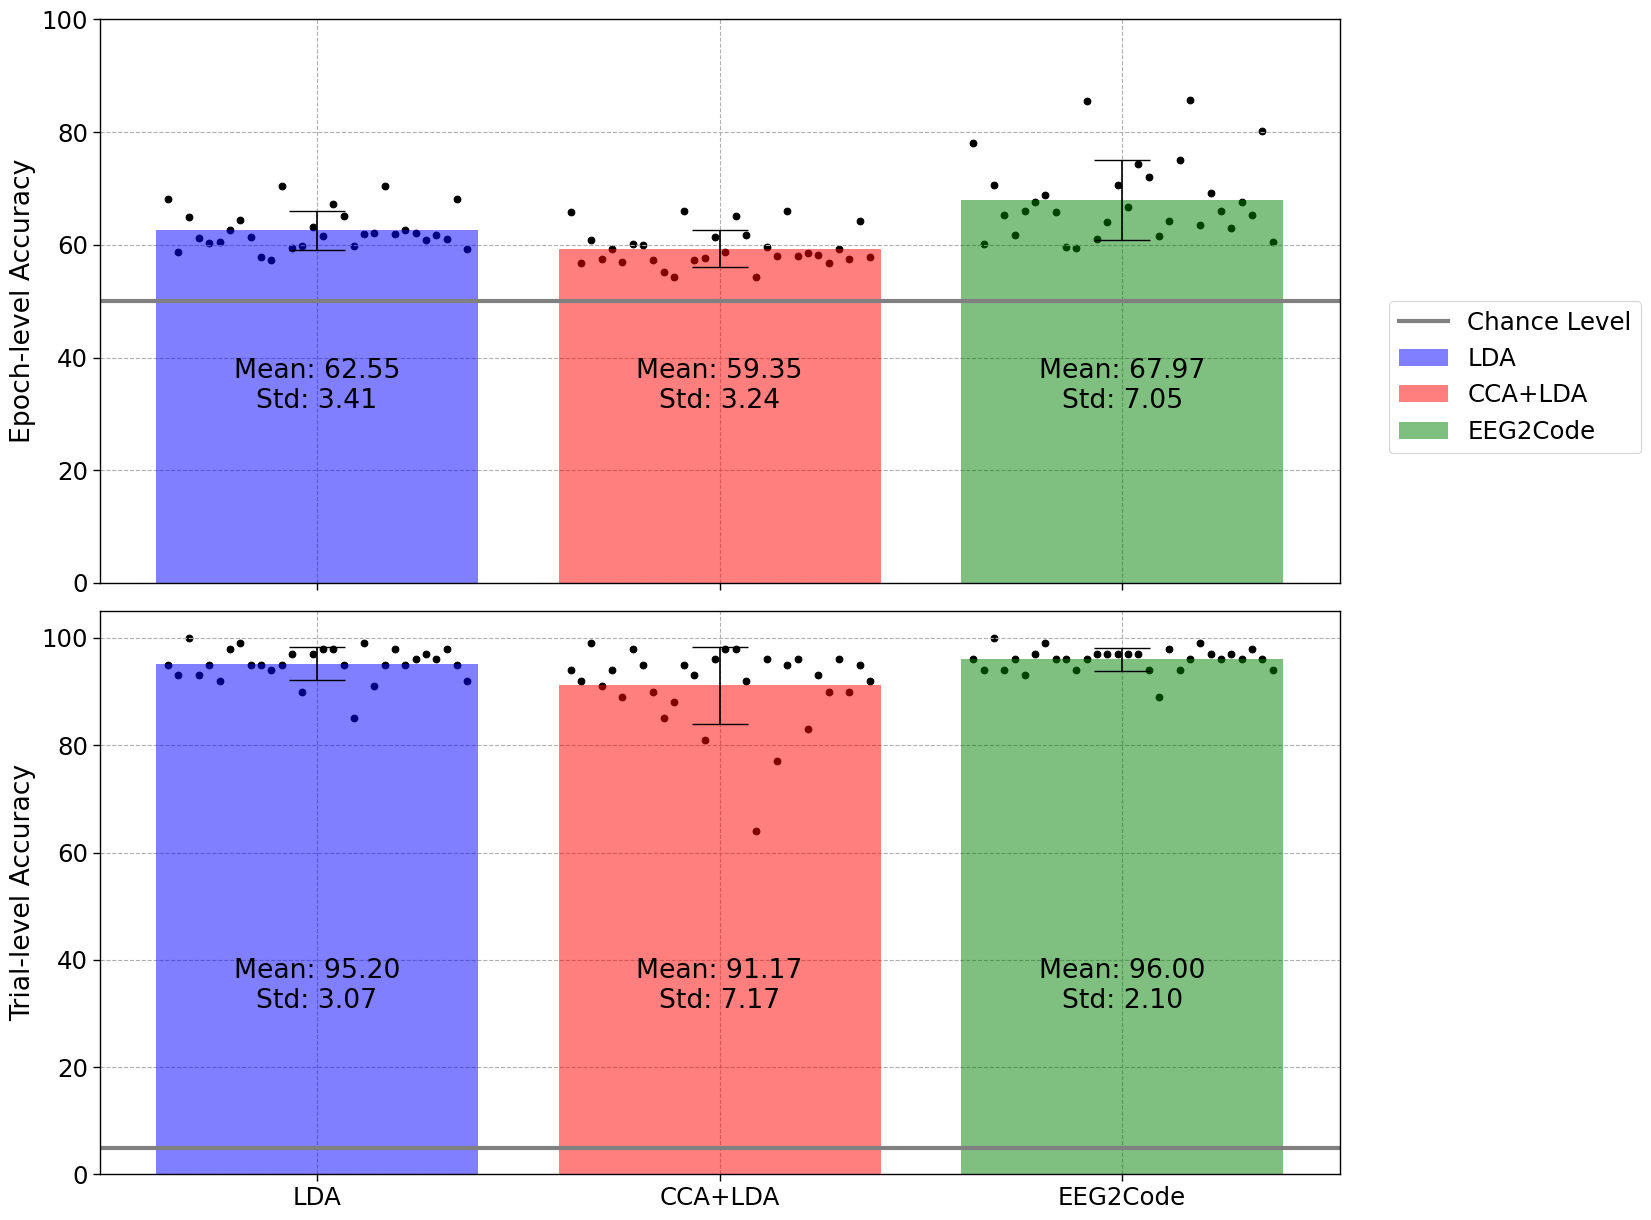

In [35]:
# Set plot setting
x = np.arange(3)
participants = ['sub-{:02d}'.format(i) for i in range(1, len(EEG2Code_acc_trial) + 1)]
bar_width=0.8

# Plot mean epoch
fig, (ax2,ax1) = plt.subplots(2,1,figsize=(16, 15))
plt.subplots_adjust(wspace=0, hspace=0.05)
bar1 = ax2.bar(x[0], LDA_acc_epoch_mean, bar_width, label='LDA', yerr=LDA_acc_epoch_std, capsize=20, zorder=2, alpha=0.5, color='blue')
bar2 = ax2.bar(x[1], CCA_acc_epoch_mean, bar_width, label='CCA+LDA', yerr=CCA_acc_epoch_std, capsize=20, zorder=2, alpha=0.5, color='red')
bar3 = ax2.bar(x[2], EEG2Code_acc_epoch_mean, bar_width, label='EEG2Code', yerr=EEG2Code_acc_epoch_std, capsize=20, zorder=2, alpha=0.5, color='green')

# Plot individual epoch accuracies as scatter plots within each bar
for i, acc_epoch in enumerate([LDA_acc_epoch, CCA_acc_epoch,EEG2Code_acc_epoch]):
    x_pos = x[i]
    for j, acc in enumerate(acc_epoch):
        ax2.scatter(x_pos -0.37 + j/39, acc, color='black')

ax2.text(x[0], 30, f'Mean: {LDA_acc_epoch_mean:.2f}\nStd: {LDA_acc_epoch_std:.2f}', ha='center', va='bottom')
ax2.text(x[1], 30, f'Mean: {CCA_acc_epoch_mean:.2f}\nStd: {CCA_acc_epoch_std:.2f}', ha='center', va='bottom')
ax2.text(x[2], 30, f'Mean: {EEG2Code_acc_epoch_mean:.2f}\nStd: {EEG2Code_acc_epoch_std:.2f}', ha='center', va='bottom')
ax2.axhline(y=50, color='grey', linestyle='-', linewidth=3, label='Chance Level')
ax2.set_xticklabels([])
ax2.set_xticks(x)
# Set y-axis label
ax2.set_ylabel('Epoch-level Accuracy')
# Set title
ax2.legend(bbox_to_anchor=(1.04, 0.5), loc='upper left', borderaxespad=0)
ax2.grid(linestyle='dashed')
ax2.set_ylim(0,100)

# Plot mean accuracies
bar4 = ax1.bar(x[0], LDA_acc_trial_mean, bar_width, label='LDA', yerr=LDA_acc_trial_std, capsize=20, zorder=2, alpha=0.5, color='blue')
bar5 = ax1.bar(x[1], CCA_acc_trial_mean, bar_width, label='CCA+LDA', yerr=CCA_acc_trial_std, capsize=20, zorder=2, alpha=0.5, color='red')
bar6 = ax1.bar(x[2], EEG2Code_acc_trial_mean, bar_width, label='EEG2Code', yerr=EEG2Code_acc_trial_std, capsize=20, zorder=2, alpha=0.5, color='green')

# Plot individual trial accuracies as scatter plots within each bar
for i, acc_trial in enumerate([LDA_acc_trial, CCA_acc_trial,EEG2Code_acc_trial]):
    x_pos = x[i]
    for j, acc in enumerate(acc_trial):
        ax1.scatter(x_pos -0.37 + j/39, acc, color='black')

ax1.text(x[0], 30, f'Mean: {LDA_acc_trial_mean:.2f}\nStd: {LDA_acc_trial_std:.2f}', ha='center', va='bottom')
ax1.text(x[1], 30, f'Mean: {CCA_acc_trial_mean:.2f}\nStd: {CCA_acc_trial_std:.2f}', ha='center', va='bottom')
ax1.text(x[2], 30, f'Mean: {EEG2Code_acc_trial_mean:.2f}\nStd: {EEG2Code_acc_trial_std:.2f}', ha='center', va='bottom')
ax1.axhline(y=5, color='grey', linestyle='-', linewidth=3, label='Chance Level')
ax1.set_xticks(x)
ax1.set_xticklabels(['LDA', 'CCA+LDA', 'EEG2Code'])
# Set y-axis label
ax1.set_ylabel('Trial-level Accuracy')
# Set title
ax1.grid(linestyle='dashed')
ax1.set_ylim(0,105)

# fig.savefig('Trial level accuracy.pdf', bbox_inches='tight')
fig.savefig('Trial level accuracy.svg', format='svg',transparent=True)
fig.savefig('Trial level accuracy.png', bbox_inches='tight')
plt.show()

### EEG decoding method means and std
### One sided paired Wilcoxon signed-rank test

In [36]:
# Print means and std
print('EEG2Code_acc_epoch: ',EEG2Code_acc_epoch)
print('EEG2Code_acc_trial: ',EEG2Code_acc_trial)
print('LDA_acc_epoch_mean: ',LDA_acc_epoch_mean)
print('LDA_acc_trial_mean: ',LDA_acc_trial_mean)
print('LDA_acc_epoch_std: ',LDA_acc_epoch_std)
print('LDA_acc_trial_std: ',LDA_acc_trial_std)
print('CCA+LDA_acc_epoch_mean: ',CCA_acc_epoch_mean)
print('CCA+LDA_acc_trial_mean: ',CCA_acc_trial_mean)
print('CCA+LDA_acc_trial_std: ',CCA_acc_epoch_std)
print('CCA+LDA_acc_trial_std: ',CCA_acc_trial_std)
print('EEG2Code_acc_epoch_mean: ',EEG2Code_acc_epoch_mean)
print('EEG2Code_acc_trial_mean: ',EEG2Code_acc_trial_mean)
print('EEG2Code_acc_epoch_std: ',EEG2Code_acc_epoch_std)
print('EEG2Code_acc_trial_std: ',EEG2Code_acc_trial_std)

# Compare LDA - EEG2Code
w, p_LDA_EEG2Code = wilcoxon(LDA_acc_epoch, EEG2Code_acc_epoch, alternative = 'less')
w, p_LDA_EEG2Code_trial = wilcoxon(LDA_acc_trial, EEG2Code_acc_trial, alternative = 'less')
print('p-value LDA EEG2Code:           ' , p_LDA_EEG2Code)
print('p-value LDA EEG2Code trials:    ', p_LDA_EEG2Code_trial)

# Compare LDA - CCA+LDA
w, p_LDA_CCA = wilcoxon(LDA_acc_epoch, CCA_acc_epoch, alternative = 'less')
w, p_LDA_CCA_trial = wilcoxon(LDA_acc_trial, CCA_acc_trial, alternative = 'less')
print('p-value LDA CCA+LDA:             ' , p_LDA_CCA)
print('p-value LDA CCA+LDA trials:      ', p_LDA_CCA_trial)

# Compare EEG2Code - CCA+LDA
w, p_EEG2Code_CCA = wilcoxon(EEG2Code_acc_epoch, CCA_acc_epoch, alternative = 'less')
w, p_EEG2Code_CCA_trial = wilcoxon(EEG2Code_acc_trial, CCA_acc_trial, alternative = 'less')
print('p-value EEG2Code CCA+LDA:        ' , p_EEG2Code_CCA)
print('p-value EEG2Code CCA+LDA trials: ', p_EEG2Code_CCA_trial)

# Compare EEG2Code - LDA
w, p_EEG2Code_LDA = wilcoxon(EEG2Code_acc_epoch, LDA_acc_epoch, alternative = 'less')
w, p_EEG2Code_LDA_trial = wilcoxon(EEG2Code_acc_trial, LDA_acc_trial, alternative = 'less')
print('p-value EEG2Code LDA:           ' , p_EEG2Code_LDA)
print('p-value EEG2Code LDA trials:    ', p_EEG2Code_LDA_trial)

# Compare CCA+LDA - LDA
w, p_CCA_LDA = wilcoxon(CCA_acc_epoch, LDA_acc_epoch, alternative = 'less')
w, p_CCA_LDA_trial = wilcoxon(CCA_acc_trial, LDA_acc_trial, alternative = 'less')
print('p-value CCA+LDA LDA:             ' , p_CCA_LDA)
print('p-value CCA+LDA LDA trials:      ', p_CCA_LDA_trial)

# Compare CCA+LDA - EEG2Code
w, p_CCA_EEG2Code = wilcoxon(CCA_acc_epoch, EEG2Code_acc_epoch, alternative = 'less')
w, p_CCA_EEG2Code_trial = wilcoxon(CCA_acc_trial, EEG2Code_acc_trial, alternative = 'less')
print('p-value CCA+LDA EEG2Code:        ' , p_CCA_EEG2Code)
print('p-value CCA+LDA EEG2Code trials: ', p_CCA_EEG2Code_trial)

p = [p_LDA_EEG2Code, p_LDA_CCA, p_EEG2Code_CCA, p_EEG2Code_LDA, p_CCA_LDA, p_CCA_EEG2Code, 
           p_LDA_EEG2Code_trial, p_LDA_CCA_trial, p_EEG2Code_CCA_trial, p_EEG2Code_LDA_trial, 
     p_CCA_LDA_trial, p_CCA_EEG2Code_trial]
p_epoch = [p_LDA_EEG2Code, p_LDA_CCA, p_EEG2Code_CCA, p_EEG2Code_LDA, p_CCA_LDA, p_CCA_EEG2Code]
p_trial = [p_LDA_EEG2Code_trial, p_LDA_CCA_trial, p_EEG2Code_CCA_trial, p_EEG2Code_LDA_trial, 
           p_CCA_LDA_trial, p_CCA_EEG2Code_trial]
from statsmodels.sandbox.stats.multicomp import multipletests
p_adjusted = multipletests(p, method='bonferroni')
p_epoch_adjusted = multipletests(p_epoch, method='bonferroni')
p_trial_adjusted = multipletests(p_trial, method='bonferroni')
print("bonferroni ",p_adjusted)
print("bonferroni epoch",p_epoch_adjusted)
print("bonferroni trial",p_trial_adjusted)

EEG2Code_acc_epoch:  [78.00694444444444, 60.12019230769231, 70.56570512820512, 65.2905982905983, 61.6650641025641, 65.94123931623932, 67.58707264957265, 68.90758547008548, 65.7451923076923, 59.558760683760696, 59.47275641025641, 85.55288461538463, 60.97916666666667, 64.02029914529915, 70.5673076923077, 66.68589743589743, 74.28685897435898, 72.02243589743588, 61.52938034188035, 64.25747863247864, 75.08814102564102, 85.71153846153847, 63.480769230769226, 69.1207264957265, 66.03525641025641, 62.99145299145299, 67.65651709401709, 65.35630341880342, 80.19337606837607, 60.565170940170944]
EEG2Code_acc_trial:  [96.0, 94.0, 100.0, 94.0, 96.0, 93.0, 97.0, 99.0, 96.0, 96.0, 94.0, 96.0, 97.0, 97.0, 97.0, 97.0, 97.0, 94.0, 89.0, 98.0, 94.0, 96.0, 99.0, 97.0, 96.0, 97.0, 96.0, 98.0, 96.0, 94.0]
LDA_acc_epoch_mean:  62.55042735042735
LDA_acc_trial_mean:  95.2
LDA_acc_epoch_std:  3.405192215913985
LDA_acc_trial_std:  3.070287717245188
CCA+LDA_acc_epoch_mean:  59.34841524216524
CCA+LDA_acc_trial_mean:

C:\Users\Sun Geun Yu\anaconda3\lib\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [37]:
# # Save test history
# if not os.path.exists(os.path.join(path, 'history2')):
#     os.makedirs(os.path.join(path, 'history2'))
# with open(os.path.join(path, 'history2', 'p_value test.txt'), 'w') as f:
#     for test in p:
#         f.write('%s\n' % test)
#     for test in p_trial:
#         f.write('%s\n' % test)